In [1]:
# !pip install tensorflow sklearn numpy matplotlib

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import os
import re

#accuracy metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


In [2]:
###testing
def load_and_separate_npy(directory):

    feature_files = sorted([f for f in os.listdir(directory) if 'features.npy' in f])
    target_files = sorted([f for f in os.listdir(directory) if 'targets.npy' in f])

    # print(f"Found {len(feature_files)} feature files and {len(target_files)} target files")

    data_by_year = {}
    for feature_file, target_file in zip(feature_files, target_files):
        year_match = re.search(r'(\d{4})\d{4}', feature_file)
        if year_match:
            year = int(year_match.group(1))
            features = np.load(os.path.join(directory, feature_file))
            targets = np.load(os.path.join(directory, target_file))

            #2D arrays check
            if len(features.shape) == 1:
                features = features.reshape(-1, 1)
            if len(targets.shape) == 1:
                targets = targets.reshape(-1, 1)

            # print(f"Loaded data for year {year}: Features shape {features.shape}, Targets shape {targets.shape}")
            data_by_year[year] = (features, targets)
    print("Done")
    return data_by_year

def prepare_data(data_by_year, train_years, val_years, test_year):


    train_features = []
    train_targets = []
    for year in train_years:
        if year in data_by_year:
            features, targets = data_by_year[year]
            train_features.append(features)
            train_targets.append(targets)


    val_features = []
    val_targets = []
    for year in val_years:
        if year in data_by_year:
            features, targets = data_by_year[year]
            val_features.append(features)
            val_targets.append(targets)


    # test_features, test_targets = data_by_year[test_year]
    test_features = []
    test_targets = []
    for year in test_year:
        if year in data_by_year:
            features, targets = data_by_year[year]
            test_features.append(features)
            test_targets.append(targets)

    train_features = np.concatenate(train_features, axis=0)
    train_targets = np.concatenate(train_targets, axis=0)
    val_features = np.concatenate(val_features, axis=0)
    val_targets = np.concatenate(val_targets, axis=0)
    test_features = np.concatenate(test_features, axis=0)
    test_targets = np.concatenate(test_targets, axis=0)

    return train_features, train_targets, val_features, val_targets, test_features, test_targets

def create_model(input_shape):

    # model = Sequential([
    #     LSTM(64, activation='tanh', return_sequences=True, input_shape=input_shape),
    #     Dropout(0.3),
    #     LSTM(32, activation='tanh', return_sequences=False),
    #     Dropout(0.3),
    #     Dense(16, activation='relu'),
    #     Dense(1)
    # ])

    # new model
    model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.3),   #(0.3)
    Dense(32, activation='relu'),
    # Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dense(1)
     ])
    return model

In [3]:
### testing ####

# If data is in Google Drive, use:
DATA_DIR = "data_5-1_array"
# If data is uploaded directly to Colab, use:
# DATA_DIR = "/content/data"

#splitting the data into train,val and test based on year
TRAIN_YEARS = range(1990, 2018)
VAL_YEARS = range(2018, 2022)
TEST_YEAR = range(2022,2025)


EPOCHS = 500
BATCH_SIZE = 16
LEARNING_RATE = 0.001      #0.001


In [4]:
train,val,test=[],[],[]
for i in TRAIN_YEARS:
    train.append(i)
print("--------")
for j in VAL_YEARS:
    val.append(j)
print("--------")
for k in TEST_YEAR:
    test.append(k)
print("--------")
print(train,"\n",val,"\n",test)
print("--------")
print(X_train.shape,y_train.shape)
print("--------")
print(X_val.shape,y_val.shape)
print("--------")
print(X_test.shape,y_test.shape)
print("--------")
print(train_features.shape)
print("--------")
print(val_features.shape)
print("--------")
print(test_features.shape)
print("--------")
# print(len(data_by_year))
# print("--------")
# print(data_by_year[2020])
# print(data_by_year[2021])
# print(data_by_year[2022])
# print(data_by_year)

--------
--------
--------
[1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017] 
 [2018, 2019, 2020, 2021] 
 [2022, 2023, 2024]
--------


NameError: name 'X_train' is not defined

In [5]:
print("Loading data...")
data_by_year = load_and_separate_npy(DATA_DIR)


print("\nPreparing datasets...")
train_features, train_targets, val_features, val_targets, test_features, test_targets = prepare_data(
    data_by_year, TRAIN_YEARS, VAL_YEARS, TEST_YEAR
)


feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_train_features = feature_scaler.fit_transform(train_features)
scaled_train_targets = target_scaler.fit_transform(train_targets)
scaled_val_features = feature_scaler.transform(val_features)
scaled_val_targets = target_scaler.transform(val_targets)
scaled_test_features = feature_scaler.transform(test_features)
scaled_test_targets = target_scaler.transform(test_targets)


#lstm takes 3 inputs (expand_dim does that)
X_train = np.expand_dims(scaled_train_features, axis=2)
y_train = scaled_train_targets
X_val = np.expand_dims(scaled_val_features, axis=2)
y_val = scaled_val_targets
X_test = np.expand_dims(scaled_test_features, axis=2)
y_test = scaled_test_targets

print("\nData shapes:")
print(f"Training: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Loading data...
Done

Preparing datasets...

Data shapes:
Training: (532, 5, 1), (532, 1)
Validation: (76, 5, 1), (76, 1)
Test: (38, 5, 1), (38, 1)


LSTM

In [6]:
print("Creating model...")
model = create_model((X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mse', metrics=['mae'])
model.summary()

Creating model...


C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
#early stopping if loss doesn't change for 15 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience= 15,    #15
    restore_best_weights=True,
    verbose=1
)
#reduce the learning rate if it stays same for 5 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,    #0.5
    patience=5,   #5
    min_lr=1e-6,       #1e-6
    verbose=1
)


print("\nTraining model...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)


Training model...
Epoch 1/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0908 - mae: 0.2297 - val_loss: 0.0326 - val_mae: 0.1559 - learning_rate: 0.0010
Epoch 2/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0305 - mae: 0.1457 - val_loss: 0.0296 - val_mae: 0.1245 - learning_rate: 0.0010
Epoch 3/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0239 - mae: 0.1164 - val_loss: 0.0203 - val_mae: 0.1061 - learning_rate: 0.0010
Epoch 4/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0190 - mae: 0.1019 - val_loss: 0.0100 - val_mae: 0.0709 - learning_rate: 0.0010
Epoch 5/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0101 - mae: 0.0742 - val_loss: 0.0050 - val_mae: 0.0540 - learning_rate: 0.0010
Epoch 6/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0053 - mae: 0.0515 - val_loss: 0.0036 - val_mae: 0.0454 - learning_rate: 0.0010
Epoch 7/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0047 - mae: 0.0498 - val_loss: 0.0016 - val_mae: 0.0312 - learning_

In [53]:
loss, mae = model.evaluate(X_train, y_train, verbose=1)
print(f"Train Loss: {loss:.4f}, Train MAE: {mae:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mae: 0.0316 
Train Loss: 0.0018, Train MAE: 0.0315


In [54]:
loss, mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Val Loss: {loss:.4f}, Val MAE: {mae:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0013 - mae: 0.0284
Val Loss: 0.0013, Val MAE: 0.0280


In [55]:
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0011 - mae: 0.0265
Test Loss: 0.0011, Test MAE: 0.0256


In [57]:
#Since the data is normalized using minmaxscaler, it should be changed to it's original form before checking accuracy (.inverse_transform)

y_pred = model.predict(X_test)
y_pred_inverse = target_scaler.inverse_transform(y_pred)
y_test_inverse = target_scaler.inverse_transform(y_test)


# mse = np.mean((y_test_inverse - y_pred_inverse) ** 2)
# mse = mean_squared_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
# mae = np.mean(np.abs(y_test_inverse - y_pred_inverse))
# mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test_inverse, y_pred_inverse)
r2 = r2_score(y_test, y_pred)
print(f"\nPerformance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Performance Metrics:
MSE: 0.0011
RMSE: 0.0330
MAE: 0.0256
R2: 0.9711


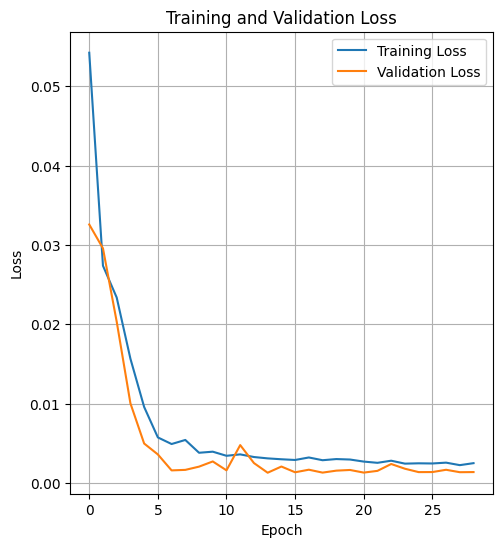

In [59]:
#subplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

LSTM+ATTENTION

In [60]:
import os
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [61]:
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_train_features = feature_scaler.fit_transform(train_features)
scaled_train_targets = target_scaler.fit_transform(train_targets)
scaled_val_features = feature_scaler.transform(val_features)
scaled_val_targets = target_scaler.transform(val_targets)
scaled_test_features = feature_scaler.transform(test_features)
scaled_test_targets = target_scaler.transform(test_targets)

X_train = np.expand_dims(scaled_train_features, axis=2)
y_train = scaled_train_targets
X_val = np.expand_dims(scaled_val_features, axis=2)
y_val = scaled_val_targets
X_test = np.expand_dims(scaled_test_features, axis=2)
y_test = scaled_test_targets

print("\nData shapes:")
print(f"Training: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")



Data shapes:
Training: (532, 5, 1), (532, 1)
Validation: (76, 5, 1), (76, 1)
Test: (57, 5, 1), (57, 1)


In [62]:

def create_lstm_transformer_model(input_shape):
    inputs = Input(shape=input_shape)

    # LSTM layer
    x = LSTM(128, activation='tanh', return_sequences=True)(inputs)
    x = Dropout(0.3)(x)

    # Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = LayerNormalization()(x + attention_output)

    # LSTM layer
    x = LSTM(64, activation='tanh', return_sequences=False)(x)
    x = Dropout(0.3)(x)

    # Dense layers
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    return Model(inputs, outputs)


model = create_lstm_transformer_model((X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 5, 1)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_10 (LSTM)                │ (None, 5, 128)            │          66,560 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_17 (Dropout)          │ (None, 5, 128)            │               0 │ lstm_10[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_2        │ (None, 5, 128)            │         131,968 │ dropout_17[0][0],          │
│ (MultiHeadAttention)          │                           │                 │ dropout_17[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 5, 128)            │               0 │ dropout_17[0][0],          │
│                               │                           │                 │ multi_head_attention_2[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_2         │ (None, 5, 128)            │             256 │ add_1[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_11 (LSTM)                │ (None, 64)                │          49,408 │ layer_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_19 (Dropout)          │ (None, 64)                │               0 │ lstm_11[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_14 (Dense)              │ (None, 32)                │           2,080 │ dropout_19[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_15 (Dense)              │ (None, 1)                 │              33 │ dense_14[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 250,305 (977.75 KB)

 Trainable params: 250,305 (977.75 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=64, #16
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - loss: 0.3296 - mae: 0.4180 - val_loss: 0.0349 - val_mae: 0.1651 - learning_rate: 0.0010
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0445 - mae: 0.1677 - val_loss: 0.0295 - val_mae: 0.1415 - learning_rate: 0.0010
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0332 - mae: 0.1471 - val_loss: 0.0225 - val_mae: 0.1193 - learning_rate: 0.0010
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0301 - mae: 0.1376 - val_loss: 0.0199 - val_mae: 0.1131 - learning_rate: 0.0010
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0275 - mae: 0.1303 - val_loss: 0.0194 - val_mae: 0.1047 - learning_rate: 0.0010
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0230 - mae: 0.1181 - val_loss: 0.0168 - val_mae: 0.1019 - learning_rate: 0.0010
Epoch 7/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0229 - mae: 0.1135 - val_loss: 0.0135 - val_mae: 0.0916 - learning_rate: 0.0010
Epoch 8/500
9/9 ━━━

In [64]:
loss, mae = model.evaluate(X_train, y_train, verbose=1)
print(f"Train Loss: {loss:.4f}, Train MAE: {mae:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018 - mae: 0.0318
Train Loss: 0.0018, Train MAE: 0.0314


In [65]:
loss, mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Val Loss: {loss:.4f}, Val MAE: {mae:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0015 - mae: 0.0298
Val Loss: 0.0014, Val MAE: 0.0286


In [66]:
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0012 - mae: 0.0271
Test Loss: 0.0011, Test MAE: 0.0267


In [67]:
y_pred = model.predict(X_test)
y_pred_inverse = target_scaler.inverse_transform(y_pred)
y_test_inverse = target_scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step

Performance Metrics:
MSE: 0.0011
RMSE: 0.0335
MAE: 0.0267
R2: 0.9702


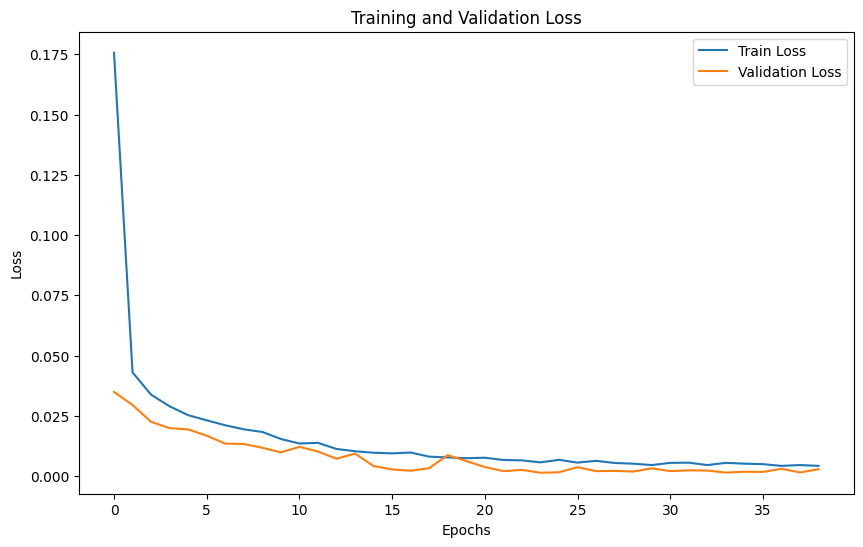

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

GRU

In [69]:
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_train_features = feature_scaler.fit_transform(train_features)
scaled_train_targets = target_scaler.fit_transform(train_targets)
scaled_val_features = feature_scaler.transform(val_features)
scaled_val_targets = target_scaler.transform(val_targets)
scaled_test_features = feature_scaler.transform(test_features)
scaled_test_targets = target_scaler.transform(test_targets)

X_train = np.expand_dims(scaled_train_features, axis=2)
y_train = scaled_train_targets
X_val = np.expand_dims(scaled_val_features, axis=2)
y_val = scaled_val_targets
X_test = np.expand_dims(scaled_test_features, axis=2)
y_test = scaled_test_targets

print("\nData shapes:")
print(f"Training: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")



Data shapes:
Training: (532, 5, 1), (532, 1)
Validation: (76, 5, 1), (76, 1)
Test: (57, 5, 1), (57, 1)


In [70]:
from tensorflow.keras.layers import Input, GRU, Dropout, Dense

In [71]:
def create_gru_model(input_shape):
    # Input Layer
    inputs = Input(shape=input_shape)

    # First GRU Layer
    x = GRU(128, activation='tanh', return_sequences=True)(inputs)
    x = Dropout(0.3)(x)

    # Second GRU Layer
    x = GRU(64, activation='tanh', return_sequences=False)(x)
    x = Dropout(0.3)(x)

    # Dense Layer
    x = Dense(32, activation='relu')(x)


    outputs = Dense(1)(x)


    return Model(inputs, outputs)


In [72]:
model = create_gru_model((X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 5, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 5, 128)              │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,665 (350.25 KB)

 Trainable params: 89,665 (350.25 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0767 - mae: 0.2062 - val_loss: 0.0214 - val_mae: 0.1264 - learning_rate: 0.0010
Epoch 2/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0193 - mae: 0.1096 - val_loss: 0.0154 - val_mae: 0.0874 - learning_rate: 0.0010
Epoch 3/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0117 - mae: 0.0803 - val_loss: 0.0055 - val_mae: 0.0581 - learning_rate: 0.0010
Epoch 4/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0069 - mae: 0.0606 - val_loss: 0.0033 - val_mae: 0.0437 - learning_rate: 0.0010
Epoch 5/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0053 - mae: 0.0530 - val_loss: 0.0011 - val_mae: 0.0263 - learning_rate: 0.0010
Epoch 6/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - mae: 0.0442 - val_loss: 0.0013 - val_mae: 0.0276 - learning_rate: 0.0010
Epoch 7/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0053 - mae: 0.0539 - val_loss: 0.0042 - val_mae: 0.0530 - learning_rate: 0.0010
Epoch 

In [74]:
loss, mae = model.evaluate(X_train, y_train, verbose=1)
print(f"Train Loss: {loss:.4f}, Train MAE: {mae:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010 - mae: 0.0246     
Train Loss: 0.0010, Train MAE: 0.0247


In [75]:
loss, mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Val Loss: {loss:.4f}, Val MAE: {mae:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.1182e-04 - mae: 0.0227
Val Loss: 0.0007, Val MAE: 0.0216


In [76]:
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 6.6241e-04 - mae: 0.0211
Test Loss: 0.0006, Test MAE: 0.0205


In [77]:
y_pred = model.predict(X_test)
y_pred_inverse = target_scaler.inverse_transform(y_pred)
y_test_inverse = target_scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step

Performance Metrics:
MSE: 0.0006
RMSE: 0.0251
MAE: 0.0205
R2: 0.9833


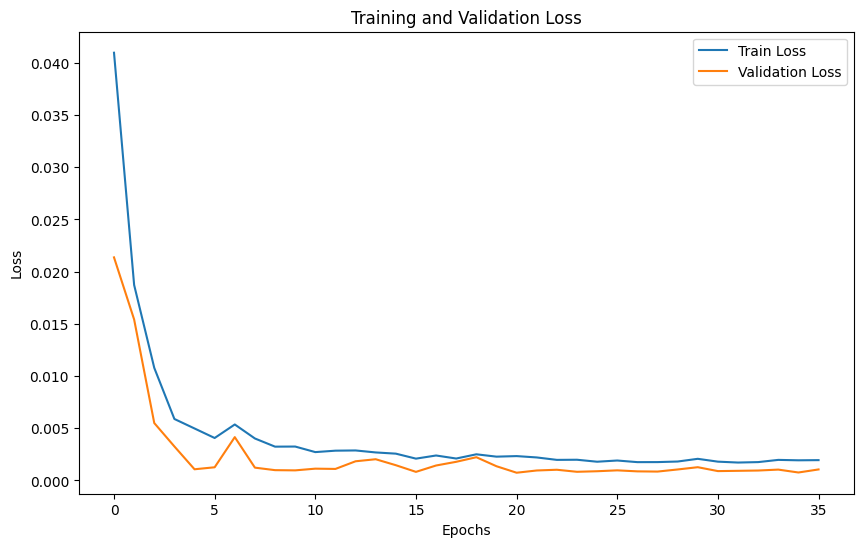

In [78]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

GRU+ATTENTION

In [83]:
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_train_features = feature_scaler.fit_transform(train_features)
scaled_train_targets = target_scaler.fit_transform(train_targets)
scaled_val_features = feature_scaler.transform(val_features)
scaled_val_targets = target_scaler.transform(val_targets)
scaled_test_features = feature_scaler.transform(test_features)
scaled_test_targets = target_scaler.transform(test_targets)

X_train = np.expand_dims(scaled_train_features, axis=2)
y_train = scaled_train_targets
X_val = np.expand_dims(scaled_val_features, axis=2)
y_val = scaled_val_targets
X_test = np.expand_dims(scaled_test_features, axis=2)
y_test = scaled_test_targets

print("\nData shapes:")
print(f"Training: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")



Data shapes:
Training: (532, 5, 1), (532, 1)
Validation: (76, 5, 1), (76, 1)
Test: (57, 5, 1), (57, 1)


In [84]:
def create_gru_transformer_model(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)

    # GRU layer to capture sequential patterns
    gru_out = GRU(128, activation='tanh', return_sequences=True)(inputs)
    gru_out = Dropout(0.3)(gru_out)

    # MultiHeadAttention layer (Transformer component)
    attention_out = MultiHeadAttention(num_heads=4, key_dim=64)(gru_out, gru_out)
    attention_out = LayerNormalization()(attention_out)
    attention_out = Dropout(0.3)(attention_out)

    # GRU layer after attention
    gru_out2 = GRU(64, activation='tanh', return_sequences=False)(attention_out)
    gru_out2 = Dropout(0.3)(gru_out2)

    # Fully connected layers
    dense_out = Dense(32, activation='relu')(gru_out2)
    output = Dense(1)(dense_out)

    # Create model
    model = Model(inputs=inputs, outputs=output)
    return model


In [85]:
model = create_gru_transformer_model((X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)   │ (None, 5, 1)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_8 (GRU)                   │ (None, 5, 128)            │          50,304 │ input_layer_10[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_26 (Dropout)          │ (None, 5, 128)            │               0 │ gru_8[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_4        │ (None, 5, 128)            │         131,968 │ dropout_26[0][0],          │
│ (MultiHeadAttention)          │                           │                 │ dropout_26[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_4         │ (None, 5, 128)            │             256 │ multi_head_attention_4[0]… │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_28 (Dropout)          │ (None, 5, 128)            │               0 │ layer_normalization_4[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_9 (GRU)                   │ (None, 64)                │          37,248 │ dropout_28[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_29 (Dropout)          │ (None, 64)                │               0 │ gru_9[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_20 (Dense)              │ (None, 32)                │           2,080 │ dropout_29[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_21 (Dense)              │ (None, 1)                 │              33 │ dense_20[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 221,889 (866.75 KB)

 Trainable params: 221,889 (866.75 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.2706 - mae: 0.3643 - val_loss: 0.0460 - val_mae: 0.1613 - learning_rate: 0.0010
Epoch 2/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0402 - mae: 0.1576 - val_loss: 0.0280 - val_mae: 0.1372 - learning_rate: 0.0010
Epoch 3/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0344 - mae: 0.1438 - val_loss: 0.0267 - val_mae: 0.1254 - learning_rate: 0.0010
Epoch 4/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0311 - mae: 0.1314 - val_loss: 0.0258 - val_mae: 0.1211 - learning_rate: 0.0010
Epoch 5/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0309 - mae: 0.1346 - val_loss: 0.0109 - val_mae: 0.0811 - learning_rate: 0.0010
Epoch 6/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0193 - mae: 0.1089 - val_loss: 0.0067 - val_mae: 0.0680 - learning_rate: 0.0010
Epoch 7/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0148 - mae: 0.0952 - val_loss: 0.0060 - val_mae: 0.0594 - learning_rate: 0.0010
Epoch

In [87]:
loss, mae = model.evaluate(X_train, y_train, verbose=1)
print(f"Train Loss: {loss:.4f}, Train MAE: {mae:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - mae: 0.0415
Train Loss: 0.0027, Train MAE: 0.0421


In [88]:
loss, mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Val Loss: {loss:.4f}, Val MAE: {mae:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0022 - mae: 0.0376
Val Loss: 0.0020, Val MAE: 0.0358


In [89]:
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0015 - mae: 0.0297
Test Loss: 0.0015, Test MAE: 0.0295


In [90]:
y_pred = model.predict(X_test)
y_pred_inverse = target_scaler.inverse_transform(y_pred)
y_test_inverse = target_scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step

Performance Metrics:
MSE: 0.0015
RMSE: 0.0383
MAE: 0.0295
R2: 0.9610


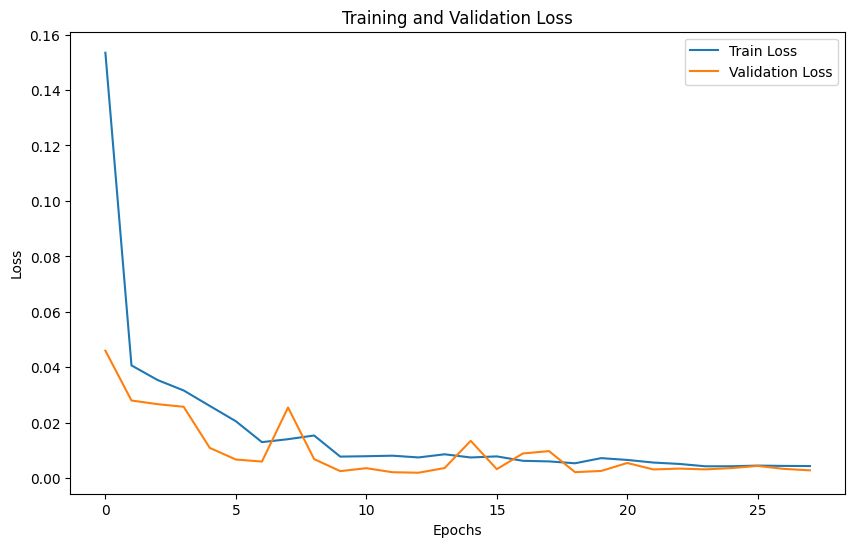

In [92]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

INTERPRETATION

In [93]:
prediction_save_path = "predicted_next_year_utci.npy"
np.save(prediction_save_path, y_pred_inverse)
print(f"\nPredicted UTCI for next year saved at {prediction_save_path}")


Predicted UTCI for next year saved at predicted_next_year_utci.npy


In [94]:
prediction_save_path = "actual_next_year_utci.npy"
np.save(prediction_save_path, y_test_inverse)
print(f"\nActual UTCI for next year saved at {prediction_save_path}")


Actual UTCI for next year saved at actual_next_year_utci.npy


In [95]:
import pandas as pd
npy_file_pred = 'predicted_next_year_utci.npy'
npy_file_true = 'actual_next_year_utci.npy'
data_pred = np.load(npy_file_pred)
data_true = np.load(npy_file_true)

data_pred_flat = data_pred.flatten()
data_true_flat = data_true.flatten()

print(data_pred_flat.shape)
print(data_true_flat.shape)
print(data_pred)
print(data_pred_flat)
print(data_true)
print(data_true_flat)
combined_data = np.column_stack((data_pred_flat, data_true_flat))

df = pd.DataFrame(combined_data, columns=['Predicted', 'Actual'])

df.to_csv('predictions_vs_actuals.csv', index=False)

print("CSV file has been created.")

(57,)
(57,)
[[35.413254]
 [36.632465]
 [36.869316]
 [36.783474]
 [36.200233]
 [35.1217  ]
 [34.027065]
 [32.796375]
 [31.654602]
 [30.03744 ]
 [29.289034]
 [28.929626]
 [28.905714]
 [29.23993 ]
 [29.351357]
 [29.33535 ]
 [29.30588 ]
 [29.200182]
 [28.976887]
 [34.39053 ]
 [35.372673]
 [36.133106]
 [36.32725 ]
 [36.182743]
 [35.63598 ]
 [35.054863]
 [34.23626 ]
 [32.911617]
 [31.079473]
 [29.677011]
 [29.304953]
 [29.089237]
 [29.145138]
 [29.163393]
 [29.070044]
 [29.088327]
 [29.169212]
 [29.229416]
 [34.39907 ]
 [35.772137]
 [36.053177]
 [36.057316]
 [35.660496]
 [34.87162 ]
 [33.58886 ]
 [31.928753]
 [30.547583]
 [29.555267]
 [29.154387]
 [28.992607]
 [29.10016 ]
 [29.111565]
 [28.91929 ]
 [28.768446]
 [28.670841]
 [28.520834]
 [28.326538]]
[35.413254 36.632465 36.869316 36.783474 36.200233 35.1217   34.027065
 32.796375 31.654602 30.03744  29.289034 28.929626 28.905714 29.23993
 29.351357 29.33535  29.30588  29.200182 28.976887 34.39053  35.372673
 36.133106 36.32725  36.182743 35.

In [96]:
df=pd.read_csv("predictions_vs_actuals.csv")
# df

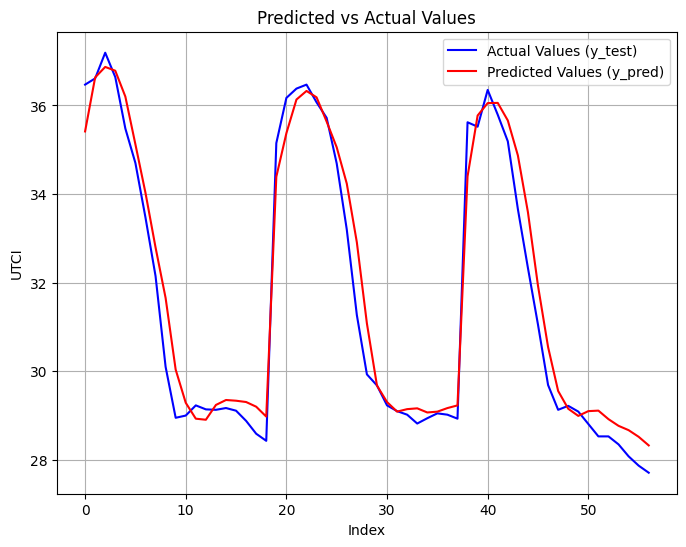

In [97]:
y_pred = df['Predicted']
y_test = df['Actual']
# print(y_pred,y_test)

plt.figure(figsize=(8, 6))

plt.plot(y_test, label='Actual Values (y_test)', color='blue', linestyle='-')
plt.plot(y_pred, label='Predicted Values (y_pred)', color='red', linestyle='-')


plt.title('Predicted vs Actual Values')
plt.xlabel('Index')
plt.ylabel('UTCI')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()